# Autoencoder
This notebook makes use of the **Autoencoder**, which is used to reduce the dimensionality of our dataset in a non-linear way. Furthermore, we then apply **k-means Clustering** as in our last notebook in our new created **Latent Space** in lower dimension. We do so, to get rid of less important variables and achieve a better Clustering.

In [1]:
!pip install cartopy xarray matplotlib netCDF4 torch

In [2]:
import helper_functions
import importlib
from ipywidgets import FloatSlider
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, IntSlider
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

## Data Loading & Preprocessing

In [27]:
ds = xr.open_dataset("/home/jovyan/spatiotemporal-mining-medsea/data/medsea.nc")
# ds = ds.sel(time=slice("2000-01-01", "2004-12-31")).load()
print(ds.nbytes / 1e6, "MB")

def preprocessing(features: list, depths: list, dim):
    """
    feature: List of features to combine. "sol" for Salinity or "temperature for Temperature.
    depth: "Any value from 0 to 1062, but it will assign the closest existing."

    returns a stacked array of the "feature".
    """

    def standardize(group):
        m = group.mean("time")
        s = group.std("time")
        s = s.where(s > 1e-6, other=1.0)  # sichere Varianz, vermeidet NaNs
        return (group - m) / s


    feature_vectors = []
    for feature in features:

        for depth in depths:
            data = ds[feature].sel(depth=depth, method="nearest")
        
            z = data.groupby("time.dayofyear").apply(standardize)
            z = z.stack(location=("latitude", "longitude"))
            feature_vectors.append(z)
    
    z_concat = xr.concat(feature_vectors, dim=dim)
    z_concat = z_concat.dropna(dim="location", how="all")

    return z_concat  # → xarray.DataArray mit dims: ("time", "location")

20554.545012 MB


In [28]:
z_temp = preprocessing(["thetao"], [50], "location")
X = z_temp.values
input_dimension = X.shape[1]
print(z_temp.nbytes / 1e6, "MB")
print(X.shape[1])

111.237552 MB
40657


## Splitting

In [31]:
X = X.astype(np.float32).copy()
X_train, X_test = train_test_split(X, test_size=0.2, random_state=27)

train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train)), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=256, shuffle=False)

## The Architecture

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        # Shared encoder backbone
        self.encoder_shared = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        # Separate layers for mean and log-variance
        self.mu_layer = nn.Linear(64, latent_dim)
        self.logvar_layer = nn.Linear(64, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder_shared(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

## Loss Function

In [7]:
def vae_loss(x_recon, x, mu, logvar, beta=1e-3):
    recon_loss = F.mse_loss(x_recon, x, reduction='mean')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss.item(), kl_div.item()


In [8]:
def get_beta(epoch, total_epochs, max_beta=1e-1):
    return max_beta * (epoch / total_epochs)

## Training

In [9]:
def train(num_epochs: int, kl_beta=1e-3):

    torch.cuda.empty_cache()
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        
        kl_beta = get_beta(epoch, num_epochs) if kl_beta == -1 else kl_beta
        model.train()
        running_train_loss = 0.0
        # kl_beta = min(1e-3, epoch / 10 * 1e-4)
        for batch in train_loader:
            x = batch[0].to(device).float()
            optimizer.zero_grad()
            x_recon, mu, logvar = model(x)
            loss, recon, kl = vae_loss(x_recon, x, mu, logvar, beta=kl_beta)

            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * x.size(0)
    
        train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
    
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0].to(device).float()
                x_recon, mu, logvar = model(x)
                loss, recon, kl = vae_loss(x_recon, x, mu, logvar, beta=kl_beta)

                running_val_loss += loss.item() * x.size(0)
    
        val_loss = running_val_loss / len(test_loader.dataset)
        val_losses.append(val_loss)
    
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Recon: {recon:.4f} | KL: {kl:.4f}")

    return train_losses, val_losses

## Setup

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training using device: {device}')

model = VariationalAutoencoder(input_dim=input_dimension, latent_dim=9).float().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100
train_losses, val_losses = train(num_epochs,kl_beta=1e-3)

Training using device: cuda
Epoch 1/100 | Train Loss: 1.0056 | Val Loss: 1.0097 | Recon: 0.9989 | KL: 10.8471
Epoch 2/100 | Train Loss: 1.0148 | Val Loss: 0.9972 | Recon: 0.9942 | KL: 3.0225
Epoch 3/100 | Train Loss: 1.0060 | Val Loss: 0.9971 | Recon: 0.9936 | KL: 3.4963
Epoch 4/100 | Train Loss: 1.0061 | Val Loss: 0.9921 | Recon: 0.9876 | KL: 4.5183
Epoch 5/100 | Train Loss: 1.0004 | Val Loss: 0.9866 | Recon: 0.9768 | KL: 9.8336
Epoch 6/100 | Train Loss: 0.9919 | Val Loss: 0.9595 | Recon: 0.9378 | KL: 21.6797
Epoch 7/100 | Train Loss: 0.9619 | Val Loss: 0.9213 | Recon: 0.8652 | KL: 56.1428
Epoch 8/100 | Train Loss: 0.9211 | Val Loss: 0.8695 | Recon: 0.8336 | KL: 35.8468
Epoch 9/100 | Train Loss: 0.8702 | Val Loss: 0.8342 | Recon: 0.8045 | KL: 29.7415
Epoch 10/100 | Train Loss: 0.8294 | Val Loss: 0.8037 | Recon: 0.7843 | KL: 19.4523
Epoch 11/100 | Train Loss: 0.8002 | Val Loss: 0.8055 | Recon: 0.7899 | KL: 15.6720
Epoch 12/100 | Train Loss: 0.8025 | Val Loss: 0.7890 | Recon: 0.7751 | K

## Evaluation

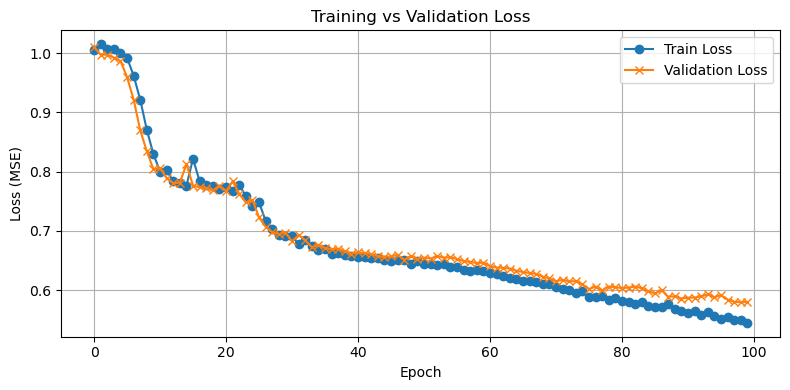

In [33]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

latents_mu = []
latents_logvar = []

with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to(device).float()
        _, mu, logvar = model(x)
        latents_mu.append(mu.cpu())
        latents_logvar.append(logvar.cpu())

# Alles zusammenfügen
mu_all = torch.cat(latents_mu, dim=0)           # shape: (n_samples, latent_dim)
logvar_all = torch.cat(latents_logvar, dim=0)   # shape: (n_samples, latent_dim)

# Statistiken
mu_std = mu_all.std(dim=0)
logvar_mean = logvar_all.mean(dim=0)
logvar_std = logvar_all.std(dim=0)

# Ausgabe
print("Std of mu per latent dim:")
print(mu_std)

print("\nMean of logvar per latent dim:")
print(logvar_mean)

print("\nStd of logvar per latent dim:")
print(logvar_std)


Std of mu per latent dim:
tensor([1.2962, 1.5867, 1.5938, 1.2345, 1.6772, 2.4903, 1.3477, 1.7693, 1.0990])

Mean of logvar per latent dim:
tensor([-2.3773, -3.1208, -3.3052, -3.1538, -3.6067, -4.1167, -2.3852, -3.3982,
        -1.3331])

Std of logvar per latent dim:
tensor([1.3142, 1.6983, 1.4371, 1.4296, 1.5859, 1.6574, 1.7188, 1.4391, 1.1404])


## Clustering with K-Means

In [35]:
from sklearn.cluster import KMeans
import torch

def get_latents_and_cluster(model, X, n_clusters=5, batch_size=512, device="cpu"):
    """
    Computes the latent representations (mu) for all inputs and clusters them using KMeans.

    Parameters:
    - model: Trained VariationalAutoencoder
    - X: Input data as a numpy array or torch.Tensor of shape (n_samples, input_dim)
    - n_clusters: Number of clusters for KMeans
    - batch_size: Batch size for efficient computation
    - device: Device to run the model on ("cpu" or "cuda")

    Returns:
    - latents: Tensor of shape (n_samples, latent_dim)
    - cluster_labels: Numpy array of shape (n_samples,) with cluster assignments
    """

    model.eval()
    model.to(device)

    if isinstance(X, torch.Tensor):
        X_tensor = X
    else:
        X_tensor = torch.tensor(X, dtype=torch.float32)

    X_tensor = X_tensor.to(device)
    latents = []

    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            batch = X_tensor[i:i+batch_size]
            h = model.encoder_shared(batch)
            mu = model.mu_layer(h)
            latents.append(mu.cpu())

    latents = torch.cat(latents, dim=0)  # (n_samples, latent_dim)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latents.numpy())

    return latents, cluster_labels


In [36]:
latents, labels= get_latents_and_cluster(model, X, n_clusters = 9, batch_size=16)
labels+=1

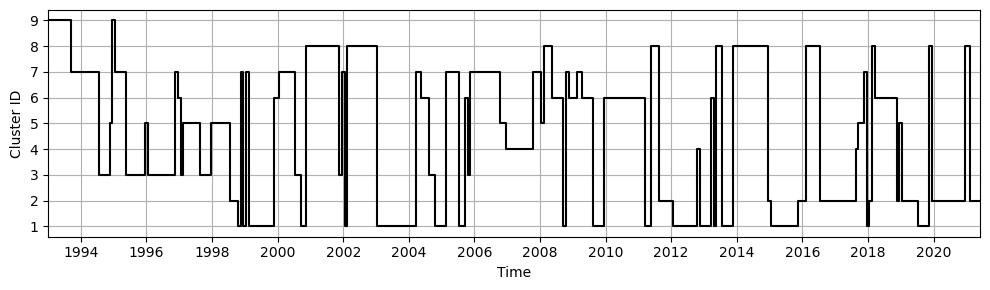

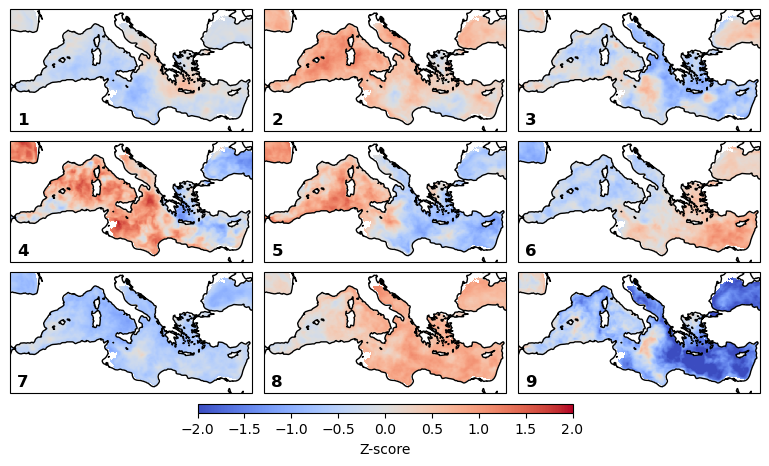

In [37]:
"""Here we preprocess only the temperature since we want
# to only cluster the temperature's z-scores in the plots."""
helper_functions.plot_cluster_timeline(z_temp, labels)

z_temp = preprocessing(["thetao"], [50], "location") 
helper_functions.plot_average_cluster(z_temp, labels, -2, 2)